In [ ]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install qiskit-finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
from qiskit_finance.applications.optimization import PortfolioDiversification

In [ ]:
%matplotlib inline

In [ ]:
# set number of assets (= number of qubits)

seed = 123

assets = ["JPM", "GS", "MSFT", "WMT"]


# Using data from yahoo finance
# use the name listed for particular company that you wish to add

data = YahooDataProvider(
        tickers= assets , 
        start=datetime.datetime(2011, 1, 1),
        end=datetime.datetime(2015, 12, 31),
    )

num_assets = len(assets)
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
rho = data.get_similarity_matrix()
# print(rho)

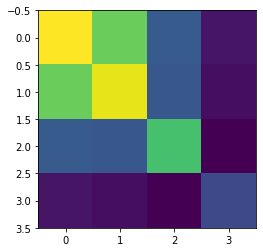

In [ ]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [ ]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term


portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00014417234623222787*x_0^2 + 0.00023453224833170..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [ ]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        row = [x, value, probability]
        writer.writerow(row)
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()

In [ ]:
#classical reference solution
#provide fname ='complete address/location of your .csv file'

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = 'nes1.csv' #change the location and nsame of .csv file

print_result(result,fname)

Optimal: selection [1. 0. 1. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.0010		1.0000
 [1 1 1 1]	4.0110		0.0000
 [0 1 1 1]	1.0022		0.0000
 [1 0 1 1]	1.0019		0.0000
 [0 0 1 1]	-0.0008		0.0000
 [1 1 0 1]	1.0026		0.0000
 [0 1 0 1]	-0.0002		0.0000
 [1 0 0 1]	-0.0006		0.0000
 [0 0 0 1]	1.0027		0.0000
 [1 1 1 0]	1.0022		0.0000
 [0 1 1 0]	-0.0006		0.0000
 [0 0 1 0]	1.0023		0.0000
 [1 1 0 0]	-0.0003		0.0000
 [0 1 0 0]	1.0028		0.0000
 [1 0 0 0]	1.0025		0.0000
 [0 0 0 0]	4.0117		0.0000


In [ ]:
!pip install qiskit-aer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# VQE solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = 'vqe1.csv' #change the location and name of .csv file
print_result(result, fname)
# print(result)

# [1. 0. 1. 0.] --numpy exact solver

Optimal: selection [1. 0. 1. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0006		0.7492
 [0 0 1 1]	-0.0008		0.1429
 [1 1 0 0]	-0.0003		0.0861
 [0 1 1 0]	-0.0006		0.0216
 [0 1 0 0]	1.0028		0.0001
 [1 1 1 0]	1.0022		0.0001
 [1 0 1 0]	-0.0010		0.0000
 [0 1 1 1]	1.0022		0.0000
 [0 0 1 0]	1.0023		0.0000
 [0 0 0 1]	1.0027		0.0000
 [1 0 1 1]	1.0019		0.0000
 [1 1 0 1]	1.0026		0.0000
 [1 0 0 0]	1.0025		0.0000
 [0 0 0 0]	4.0117		0.0000
 [1 1 1 1]	4.0110		0.0000
 [0 1 0 1]	-0.0002		0.0000


In [ ]:
# QAOA solution
#provide fname ='complete address/location of your .csv file'

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = 'qaoa1.csv' #change the location and name of .csv file
print_result(result, fname)

# [1. 0. 1. 0.]  -numpy exact solver

Optimal: selection [1. 0. 1. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	-0.0002		0.1474
 [1 1 0 0]	-0.0003		0.1474
 [1 0 0 1]	-0.0006		0.1474
 [0 1 1 0]	-0.0006		0.1474
 [0 0 1 1]	-0.0008		0.1473
 [1 0 1 0]	-0.0010		0.1473
 [0 0 1 0]	1.0023		0.0136
 [0 0 0 1]	1.0027		0.0135
 [1 1 1 0]	1.0022		0.0135
 [1 0 0 0]	1.0025		0.0135
 [1 0 1 1]	1.0019		0.0135
 [0 1 0 0]	1.0028		0.0134
 [0 1 1 1]	1.0022		0.0134
 [1 1 0 1]	1.0026		0.0134
 [1 1 1 1]	4.0110		0.0040
 [0 0 0 0]	4.0117		0.0040


### exact solver, VQE and QAOA is producing same results for 4 assets.


## weight allocation part after asset selection using quantum

In [ ]:
selected_assets = [1, 0, 1, 0]
assets = ["JPM", "GS", "MSFT", "WMT"]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['JPM', 'MSFT']


In [ ]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2011-1-1', end = '2015-12-31')['Adj Close']
selected_stocks_data.head()

[*********************100%***********************]  2 of 2 completed


,JPM,MSFT
Date,,
2011-01-03,31.665409,21.917931
2011-01-04,32.123692,22.004093
2011-01-05,32.516518,21.933596
2011-01-06,32.356480,22.575937
2011-01-07,31.745434,22.403603


In [ ]:
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
log_return.head()

,JPM,MSFT
Date,,
2011-01-03,NaN,NaN
2011-01-04,0.014369,0.003923
2011-01-05,0.012154,-0.003209
2011-01-06,-0.004934,0.028865
2011-01-07,-0.019065,-0.007663


In [ ]:
import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.78011972 0.21988028]


In [ ]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 250
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [ ]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [ ]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets)))

In [ ]:
# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.3, 0.7]
# tuple((0, 1) for stocks in range(len(my_assets)))

In [ ]:
neg_sharpe(weights)

-0.5136496243691085

In [ ]:
# from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -0.7145377189710492
     jac: array([ 5.27106225e-04, -6.54086471e-05])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.11040063, 0.88959937])

In [ ]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [ ]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [ ]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'JPM': 0.11040063206962557, 'MSFT': 0.8895993679303744}

In [ ]:
my_assets

['JPM', 'MSFT']

In [ ]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  0.8225826168489629


In [ ]:
risk_ret_dict_of_quantum

{'returns': 16.17328156677848,
 'risk': 19.661589286596982,
 'sharpe_ratio': 0.8225826168489629}

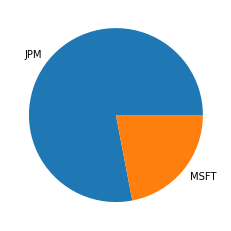

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

In [ ]:
# 4_stocks= ["JPM", "GS", "MSFT", "WMT"]
# 6_stocks= ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]
# 8_stocks= ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE"]
# 10_stocks=["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "DIS", "BA", "MCD", "NKE"]

## MPT CODE to benchmark 

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [ ]:
NUM_TRADING_DAYS = 252 #252*5 cosnidered previously
NUM_PORTFOLIOS = 10000
stocks = ["JPM", "GS", "MSFT", "WMT"]

In [ ]:
start_date = '2011-01-01' # YY/MM/DD
end_date = '2015-12-31'   # YY/MM/DD

In [ ]:
def download_data():
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date, )['Close']

    return pd.DataFrame(stock_data)

In [ ]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()

# show_data(data)

In [ ]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [ ]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [ ]:
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)
    print("sharpe ratio of a portfolio is ", portfolio_return/portfolio_volatility)

In [ ]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [ ]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [ ]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [ ]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

In [ ]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [ ]:
def optimize_portfolio(weights, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)


In [ ]:
def print_optimal_portfolio(optimum, returns):
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))


In [ ]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


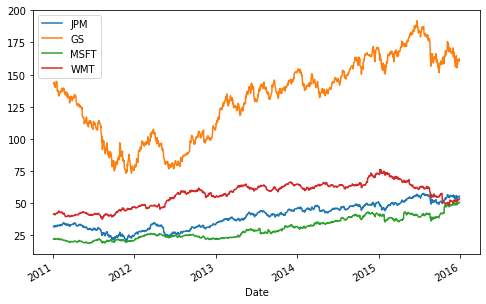

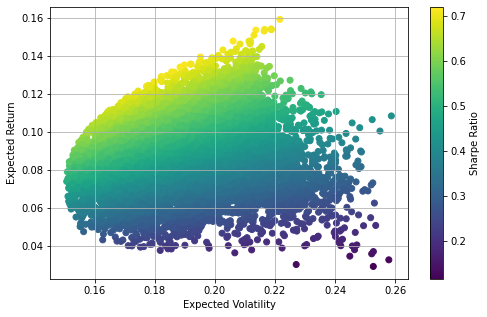

Optimal Portfolio:  [0.085 0.    0.812 0.103]
Expected return, volatility and sharpe ratio:  [0.15104289 0.20915443 0.72215967]


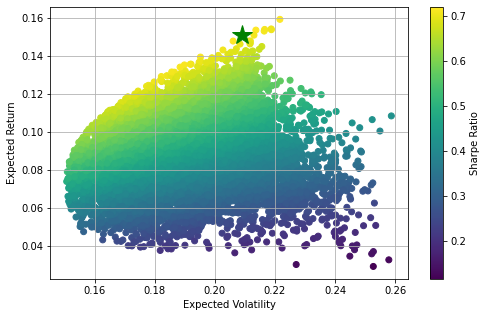

In [ ]:
if __name__ == '__main__':
    # print(download_data())
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    # show_mean_variance(log_daily_returns, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [ ]:
risk_ret_dict_of_quantum

{'returns': 16.17328156677848,
 'risk': 19.661589286596982,
 'sharpe_ratio': 0.8225826168489629}